In [1]:
import spateo as st
import dynamo as dyn
import anndata

2023-10-11 13:54:14.099805: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 13:54:14.143298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:54:14.737791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cur

In [2]:
import os

os.chdir('/home/mowp/workspace/single_cell_analysis/spateo')

In [3]:
# Load binning data
fname_bin60 = "mousebrain_bin60.h5ad"
# adata_bin60 = st.sample_data.mousebrain(fname_bin60)
adata_bin60 = anndata.read_h5ad(fname_bin60)
adata_bin60

AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area', 'n_counts'
    uns: '__type', 'pp', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'

In [4]:
adata_bin60.obs

# n_counts: adata_bin60.X.sum(axis=1)

,area,n_counts
10-41,3600,666.0
10-42,3600,1260.0
10-43,3600,3332.0
10-44,3600,2743.0
10-45,3600,3714.0
...,...,...
99-89,3600,4979.0
99-9,3600,2908.0
99-90,3600,4430.0
99-91,3600,2316.0


# Normalization & Dimensional reduction

In [5]:
# Preprocessing
st.pp.filter.filter_genes(adata_bin60, min_cells=3, inplace=True)

# Normalization
dyn.pp.normalize_cell_expr_by_size_factors(adata_bin60, layers="X")

# Linear reduction
st.tl.pca_spateo(adata_bin60, n_pca_components=30)

# Identify neighbors(KNN)
dyn.tl.neighbors(adata_bin60, n_neighbors=30)

|-----> Set <adata.X> to normalized data


/tmp/ipykernel_1940632/3851410998.py:5: DeprecationWarning:

normalize_cell_expr_by_size_factors is deprecated and will be removed in a future release. Please update your code to use the new replacement function.



|-----> Runing PCA on adata.X...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size'
    var: 'pass_basic_filter'
    uns: '__type', 'pp', 'spatial', 'neighbors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Vanilla louvain clustering

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [27.9425s]


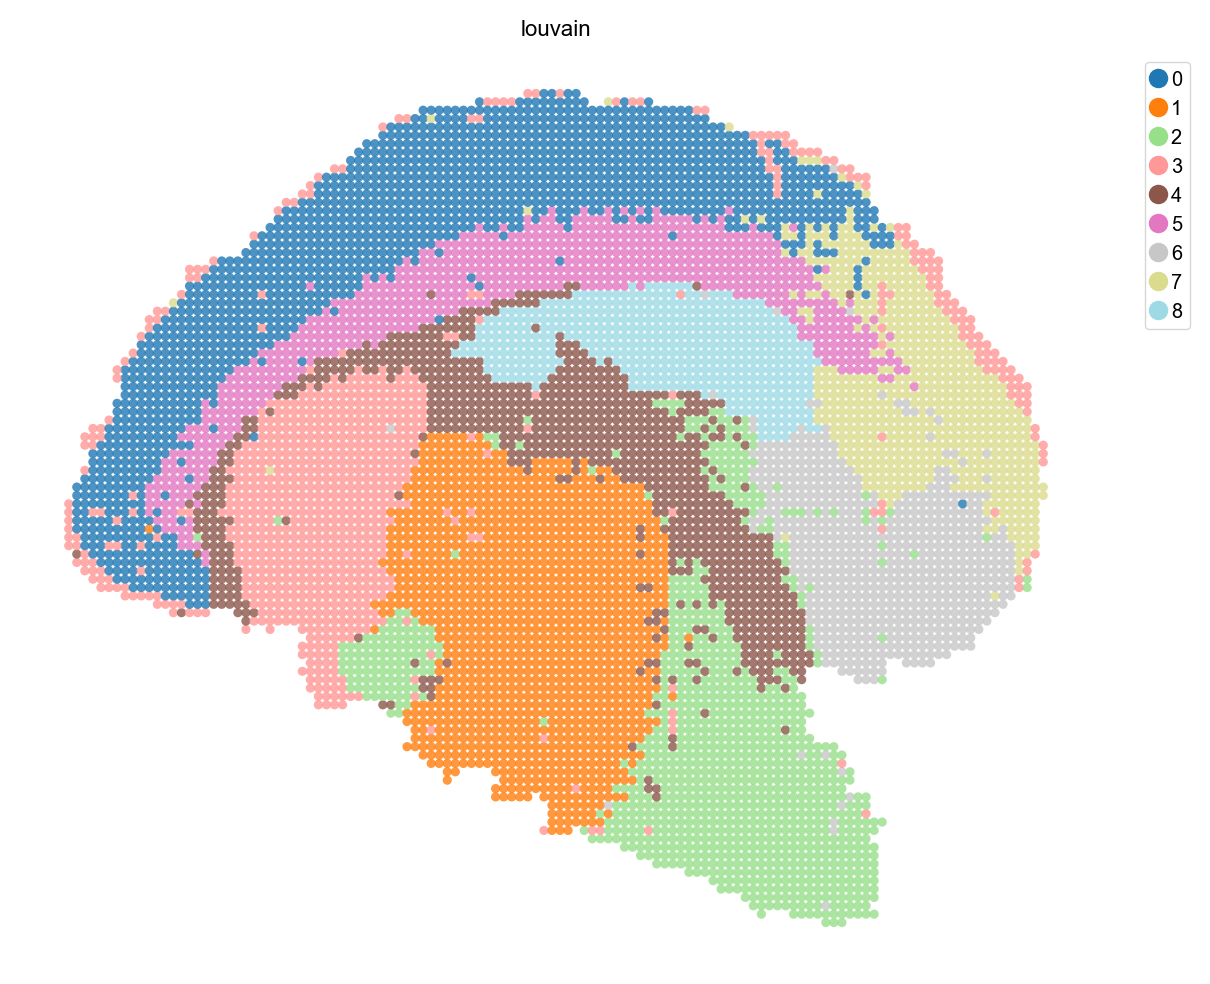

In [12]:
#louvain clustering
dyn.tl.louvain(adata_bin60, resolution=.45)
st.pl.space(adata_bin60, color=['louvain'], show_legend="upper left", figsize=(8, 6), color_key_cmap="tab20")

In [17]:
adata_bin60

AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain'
    var: 'pass_basic_filter'
    uns: '__type', 'pp', 'spatial', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> using adj_matrix from arg for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [54.2161s]


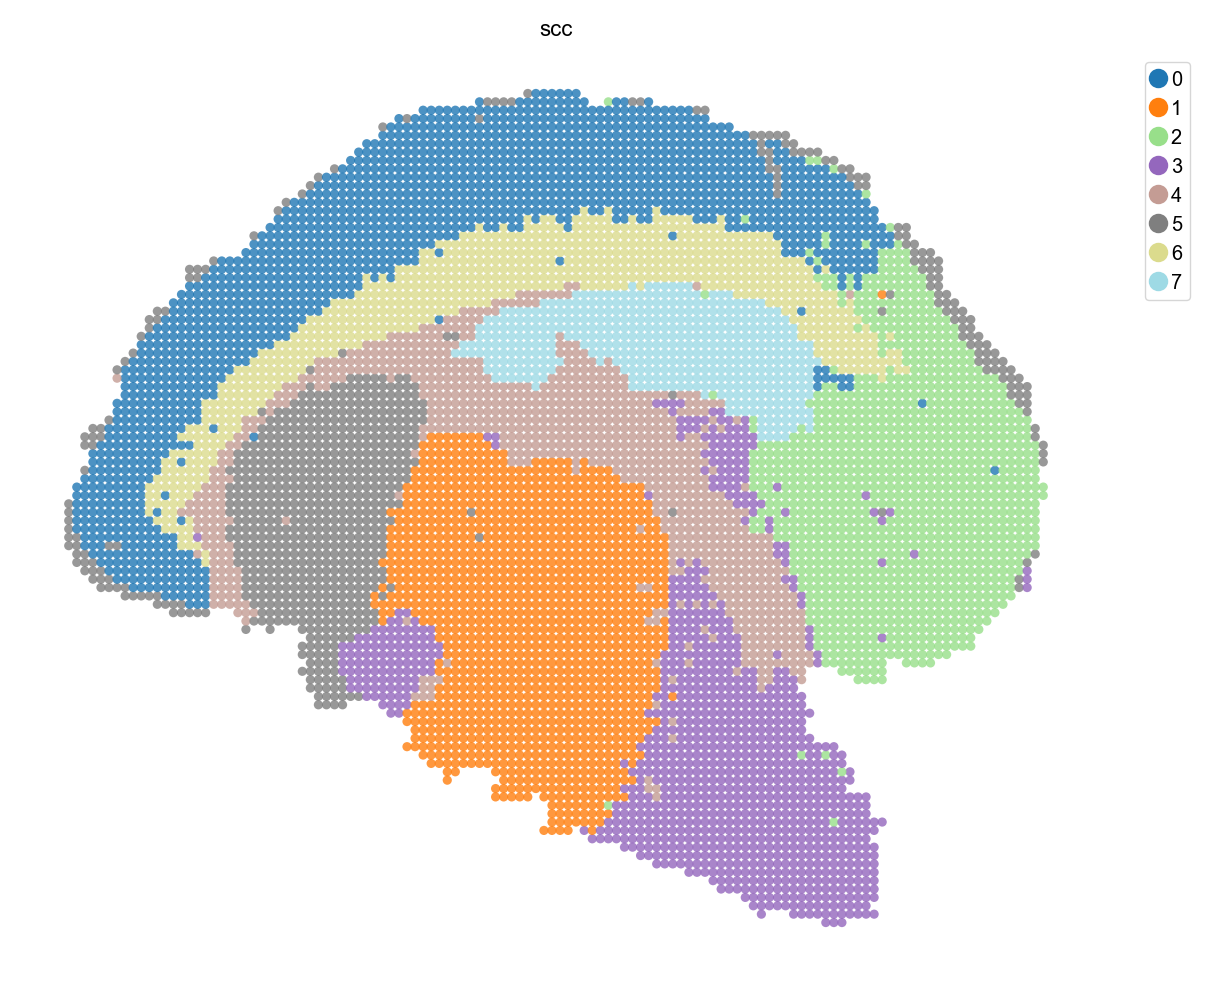

In [13]:
#scc clustering
st.tl.scc(
    adata_bin60,
    s_neigh=8,
    e_neigh=30,
    resolution=0.4,
    cluster_method="louvain",
    key_added="scc",
    pca_key="X_pca",
)
st.pl.space(adata_bin60, color=['scc'], show_legend="upper left", figsize=(8, 6), color_key_cmap="tab20")

In [26]:
adata_bin60

AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
    var: 'pass_basic_filter'
    uns: '__type', 'pp', 'spatial', 'neighbors', 'louvain', 'louvain_colors', 'spatial_neighbors', 'scc', 'scc_colors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities', 'spatial_distances', 'spatial_connectivities'